In [39]:
import os 
import pandas as pd
    
import json
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import glob
import allel
import itertools
from matplotlib import gridspec
import matplotlib.pyplot as plt
import pickle
from statannot import add_stat_annotation
from scipy import stats
import matplotlib.cm as cm
import matplotlib

from math import pi
import scipy

import matplotlib.patches as mpatches

import random

import matplotlib.colors as clr
from matplotlib.colors import ListedColormap, LinearSegmentedColormap, BoundaryNorm
from matplotlib import collections  as mc
import matplotlib.lines as mlines

pd.options.display.max_columns=200
pd.options.display.max_rows=100
from pandas.core.common import SettingWithCopyWarning
import warnings
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

### Load metadata

In [74]:
df_met = pd.read_csv("../results/data/processed_hmf_escape_info.tsv.gz",sep="\t")
df_primary = pd.read_csv("../results/data//processed_pcawg_escape_info.tsv.gz",sep="\t")
df_meta = pd.read_csv("../metadata/dataset_metadata_supp_table3.tsv",sep="\t")
df_meta=df_meta[df_meta["is_selected"]==True]
df_comb=pd.concat([df_primary,df_met])
a = df_meta.set_index("cancer_type").to_dict()["cancer_type_code"]
b = df_meta.set_index("cancer_type_code").to_dict()["cancer_type"]

/home/fran/miniconda3/envs/global/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3051: DtypeWarning: Columns (16,17,19,20,142) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


# Load data, Tumor type analysis

In [76]:
# tmb and neoepitopes features
df_tmb = pd.read_csv("../results/data/results_feature_correlation/tmb_regression.tsv",sep="\t").rename(columns={"Odds Ratio":"odds_ratio","ttype":"cancer_type_code"})
df_tmb["label"] = df_tmb["column"]
df_tmb["cat"] = "Tumor Mutation Burden"

df_tmb_control = pd.read_csv("../results/data/results_feature_correlation/tmb_regression_control.tsv",sep="\t").rename(columns={"Odds Ratio":"odds_ratio","ttype":"cancer_type_code"})
df_tmb_control["label"] = df_tmb_control["column"]
df_tmb_control["cat"] = "Tumor Mutation Burden"

# mutational signatures
df_sbs = pd.read_csv("../results/data/results_feature_correlation/mut_sig_regression.tsv",sep="\t").rename(columns={"Odds Ratio":"odds_ratio","ttype":"cancer_type_code"})
df_sbs["label"] = df_sbs.apply(lambda row: "__".join(row["column"].split("__")[1:]),axis=1)
df_sbs["cat"] = "Mutational Processes"

df_sbs_control = pd.read_csv("../results/data/results_feature_correlation/mut_sig_regression_control.tsv",sep="\t").rename(columns={"Odds Ratio":"odds_ratio","ttype":"cancer_type_code"})
df_sbs_control["label"] = df_sbs_control.apply(lambda row: "__".join(row["column"].split("__")[1:]),axis=1)
df_sbs_control["cat"] = "Mutational Processes"


# infiltration
df_infilration = pd.read_csv("../results/data/results_feature_correlation/immune_infiltration_regression.tsv",sep="\t").rename(columns={"Odds Ratio":"odds_ratio","ttype":"cancer_type_code"})
df_infilration["label"] = df_infilration.apply(lambda row: f"Immune infiltration ({row['column']})",axis=1)
df_infilration["cat"] = "Immune infiltration"

df_infilration_control = pd.read_csv("../results/data/results_feature_correlation/immune_infiltration_regression_control.tsv",sep="\t").rename(columns={"Odds Ratio":"odds_ratio","ttype":"cancer_type_code"})
df_infilration_control["label"] = df_infilration_control.apply(lambda row: f"Immune infiltration ({row['column']})",axis=1)
df_infilration_control["cat"] = "Immune infiltration"


# germline diveristy

df_germ_div = pd.read_csv("../results/data/results_feature_correlation/germ_diversity_regression.tsv",sep="\t").rename(columns={"Odds Ratio":"odds_ratio","ttype":"cancer_type_code"})
df_germ_div = df_germ_div[df_germ_div["column"]=="sum_diversity_germline"]
df_germ_div["label"] = df_germ_div.apply(lambda row: f"Germline HLA div. ({row['column']})",axis=1)
df_germ_div["cat"] = "Germline HLA diversity"

df_germ_div_control = pd.read_csv("../results/data/results_feature_correlation/germ_diversity_regression_control.tsv",sep="\t").rename(columns={"Odds Ratio":"odds_ratio","ttype":"cancer_type_code"})
df_germ_div_control = df_germ_div_control[df_germ_div_control["column"]=="sum_diversity_germline"]
df_germ_div_control["label"] = df_germ_div_control.apply(lambda row: f"Germline HLA div. ({row['column']})",axis=1)
df_germ_div_control["cat"] = "Germline HLA diversity"

# age 

df_age = pd.read_csv("../results/data/results_feature_correlation/age_regression.tsv",sep="\t").rename(columns={"Odds Ratio":"odds_ratio","ttype":"cancer_type_code"})
df_age = df_age[df_age["column"]=="age"]
df_age["label"] = df_age.apply(lambda row: f"Age at biopsy ({row['column']})",axis=1)
df_age["cat"] = "Age at biopsy"

df_age_control = pd.read_csv("../results/data/results_feature_correlation/age_regression_control.tsv",sep="\t").rename(columns={"Odds Ratio":"odds_ratio","ttype":"cancer_type_code"})
df_age_control = df_age_control[df_age_control["column"]=="age"]
df_age_control["label"] = df_age_control.apply(lambda row: f"Age at biopsy ({row['column']})",axis=1)
df_age_control["cat"] = "Age at biopsy"


# enrichment in supertypes

df_sts = pd.read_csv("../results/data/results_feature_correlation/supertypes_analysis_results.tsv",sep="\t").rename(columns={"odds":"odds_ratio","ttype":"cancer_type_code","n_samples_st":"n_samples_exposure"})
df_sts["label"] = df_sts.apply(lambda row: f"HLA-I supertype ({row['column']})",axis=1)
df_sts["cat"] = "HLA-I supertype."

df_sts_control = pd.read_csv("../results/data/results_feature_correlation/supertypes_analysis_results_control.tsv",sep="\t").rename(columns={"odds":"odds_ratio","ttype":"cancer_type_code","n_samples_st":"n_samples_exposure"})
df_sts_control["label"] = df_sts_control.apply(lambda row: f"HLA-I supertype ({row['column']})",axis=1)
df_sts_control["cat"] = "HLA-I supertype."

# enrichment in pre-treatment

df_pre = pd.read_csv("../results/data/results_feature_correlation/pretreatment_analysis_results.tsv",sep="\t").rename(columns={"odds":"odds_ratio","ttype":"cancer_type_code","n_treated":"n_samples_exposure"})
df_pre["label"] = df_pre.apply(lambda row: f"Pre-treatment ({row['column'].split('_')[1]})",axis=1)
df_pre["cat"] = "Pretreatment"

df_pre_control = pd.read_csv("../results/data/results_feature_correlation/pretreatment_analysis_results_control.tsv",sep="\t").rename(columns={"odds":"odds_ratio","ttype":"cancer_type_code","n_treated":"n_samples_exposure"})
df_pre_control["label"] = df_pre_control.apply(lambda row: f"Pre-treatment ({row['column'].split('_')[1]})",axis=1)
df_pre_control["cat"] = "Pretreatment"

# DNA -repair
df_msi_repair = pd.read_csv("../results/data/results_feature_correlation/msi_analysis_results.tsv",sep="\t").rename(columns={"odds":"odds_ratio","ttype":"cancer_type_code","n_treated":"n_samples_exposure"})
df_msi_repair["label"] = "MMRd"
df_msi_repair["cat"] = "DNA repair def."
df_msi_repair_control = pd.read_csv("../results/data/results_feature_correlation/msi_analysis_results_control.tsv",sep="\t").rename(columns={"odds":"odds_ratio","ttype":"cancer_type_code","n_treated":"n_samples_exposure"})
df_msi_repair_control["label"] = "MMRd"
df_msi_repair_control["cat"] = "DNA repair def."


df_hrd_repair = pd.read_csv("../results/data/results_feature_correlation/hrd_analysis_results.tsv",sep="\t").rename(columns={"odds":"odds_ratio","ttype":"cancer_type_code","n_treated":"n_samples_exposure"})
df_hrd_repair["label"] = "HRd"
df_hrd_repair["cat"] = "DNA repair def."
df_hrd_repair_control = pd.read_csv("../results/data/results_feature_correlation/hrd_analysis_results_control.tsv",sep="\t").rename(columns={"odds":"odds_ratio","ttype":"cancer_type_code","n_treated":"n_samples_exposure"})
df_hrd_repair_control["label"] = "HRd"
df_hrd_repair_control["cat"] = "DNA repair def."


# Viral integration
df_dna_viral = pd.read_csv("../results/data/results_feature_correlation/viral_analysis_results.tsv",sep="\t").rename(columns={"odds":"odds_ratio","ttype":"cancer_type_code","n_treated":"n_samples_exposure"})
df_dna_viral["label"] = "DNA viral insertion"
df_dna_viral["cat"] = "DNA viral insertion"

df_dna_viral_control = pd.read_csv("../results/data/results_feature_correlation/viral_analysis_results_control.tsv",sep="\t").rename(columns={"odds":"odds_ratio","ttype":"cancer_type_code","n_treated":"n_samples_exposure"})
df_dna_viral_control["label"] = "DNA viral insertion"
df_dna_viral_control["cat"] = "DNA viral insertion"

# WGD
df_wgd = pd.read_csv("../results/data/results_feature_correlation/wgd_analysis_results.tsv",sep="\t").rename(columns={"odds":"odds_ratio","ttype":"cancer_type_code","n_treated":"n_samples_exposure"})
df_wgd["label"] = "WGD"
df_wgd["cat"] = "WGD"

df_wgd_control = pd.read_csv("../results/data/results_feature_correlation/wgd_analysis_results_control.tsv",sep="\t").rename(columns={"odds":"odds_ratio","ttype":"cancer_type_code","n_treated":"n_samples_exposure"})
df_wgd_control["label"] = "WGD"
df_wgd_control["cat"] = "WGD"


# drivers

df_drivers = pd.read_csv("../results/data/results_feature_correlation/drivers_selected_excluding_lohhla.tsv",sep="\t").rename(columns={"odds":"odds_ratio","ttype":"cancer_type_code","n_treated":"n_samples_exposure"})
df_drivers["label"] = df_drivers["column"]
df_drivers["cat"] = "Drivers"

df_drivers_control = pd.read_csv("../results/data/results_feature_correlation/drivers_selected_excluding_lohhla_background.tsv",sep="\t").rename(columns={"odds":"odds_ratio","ttype":"cancer_type_code","n_treated":"n_samples_exposure"})
df_drivers_control["label"] = df_drivers_control["column"]
df_drivers_control["cat"] = "Drivers"


### Created combined dataset

In [128]:
df_total = pd.concat([df_tmb[["cancer_type_code","odds_ratio","qvalue","label","cat","5%","95%","n_samples_exposure","variable_dependent"]],
                      df_sbs[["cancer_type_code","odds_ratio","qvalue","label","cat","5%","95%","n_samples_exposure","variable_dependent"]],
                      df_infilration[["cancer_type_code","odds_ratio","qvalue","label","cat","5%","95%","n_samples_exposure","variable_dependent"]],   
                      df_germ_div[["cancer_type_code","odds_ratio","qvalue","label","cat","5%","95%","n_samples_exposure","variable_dependent"]],
                      df_age[["cancer_type_code","odds_ratio","qvalue","label","cat","5%","95%","n_samples_exposure","variable_dependent"]],
                      
                      df_sts[["cancer_type_code","odds_ratio","qvalue","label","cat","n_samples_group","variable_dependent"]].rename(columns={"n_samples_group":"n_samples_exposure"}),
                      df_pre[["cancer_type_code","odds_ratio","qvalue","label","cat","n_samples_group","variable_dependent"]].rename(columns={"n_samples_group":"n_samples_exposure"}),
                      df_msi_repair[["cancer_type_code","odds_ratio","qvalue","label","cat","n_samples_group","variable_dependent"]].rename(columns={"n_samples_group":"n_samples_exposure"}),
                      df_hrd_repair[["cancer_type_code","odds_ratio","qvalue","label","cat","n_samples_group","variable_dependent"]].rename(columns={"n_samples_group":"n_samples_exposure"}),
                      df_dna_viral[["cancer_type_code","odds_ratio","qvalue","label","cat","n_samples_group","variable_dependent"]].rename(columns={"n_samples_group":"n_samples_exposure"}),
                      df_wgd[["cancer_type_code","odds_ratio","qvalue","label","cat","n_samples_group","variable_dependent"]].rename(columns={"n_samples_group":"n_samples_exposure"}),
                      df_drivers[["cancer_type_code","odds_ratio","qvalue","label","cat","variable_dependent"]].rename(columns={"n_samples_group":"n_samples_exposure"})])
df_total = df_total[(df_total["cancer_type_code"]!="CUP")&(df_total["variable_dependent"]=="excluding_loh_hla")]
df_total["significant"] = df_total["qvalue"] < 0.05

#df_total.sort_values("qvalue").to_csv("features_correlates_ttype.tsv",sep="\t",index=False)

### Create combined dataset control

In [129]:
df_total_control = pd.concat([df_tmb_control[["cancer_type_code","odds_ratio","qvalue","label","cat","5%","95%","n_samples_exposure","variable_dependent"]],
                      df_sbs_control[["cancer_type_code","odds_ratio","qvalue","label","cat","5%","95%","n_samples_exposure","variable_dependent"]],
                      df_infilration_control[["cancer_type_code","odds_ratio","qvalue","label","cat","5%","95%","n_samples_exposure","variable_dependent"]],   
                      df_germ_div_control[["cancer_type_code","odds_ratio","qvalue","label","cat","5%","95%","n_samples_exposure","variable_dependent"]],
                      df_age_control[["cancer_type_code","odds_ratio","qvalue","label","cat","5%","95%","n_samples_exposure","variable_dependent"]],
                      
                      df_sts_control[["cancer_type_code","odds_ratio","qvalue","label","cat","n_samples_group","variable_dependent"]].rename(columns={"n_samples_group":"n_samples_exposure"}),
                      df_pre_control[["cancer_type_code","odds_ratio","qvalue","label","cat","n_samples_group","variable_dependent"]].rename(columns={"n_samples_group":"n_samples_exposure"}),
                      df_msi_repair_control[["cancer_type_code","odds_ratio","qvalue","label","cat","n_samples_group","variable_dependent"]].rename(columns={"n_samples_group":"n_samples_exposure"}),
                      df_hrd_repair_control[["cancer_type_code","odds_ratio","qvalue","label","cat","n_samples_group","variable_dependent"]].rename(columns={"n_samples_group":"n_samples_exposure"}),
                      df_dna_viral_control[["cancer_type_code","odds_ratio","qvalue","label","cat","n_samples_group","variable_dependent"]].rename(columns={"n_samples_group":"n_samples_exposure"}),
                      df_wgd_control[["cancer_type_code","odds_ratio","qvalue","label","cat","n_samples_group","variable_dependent"]].rename(columns={"n_samples_group":"n_samples_exposure"}),
                      df_drivers_control[["cancer_type_code","odds_ratio","qvalue","label","cat","variable_dependent"]].rename(columns={"n_samples_group":"n_samples_exposure"})])
df_total_control = df_total_control[(df_total_control["cancer_type_code"]!="CUP")&(df_total_control["variable_dependent"].str.contains("excluding_lohhla"))]
df_total_control["significant"] = df_total_control["qvalue"] < 0.05

#df_total_control.sort_values("qvalue").to_csv("features_correlates_ttype.tsv",sep="\t",index=False)

# Process full GIE

### Create background

In [130]:
df_total_control.set_index(["label","cancer_type_code"],inplace=True)
l=[]
for label,cancer_type_code in tqdm(set(df_total_control.index)):
    tmp=df_total_control.loc[(label,cancer_type_code)]
    freq_positive=tmp[(tmp["significant"])&((tmp["odds_ratio"]>0)|(np.isposinf(tmp["odds_ratio"])))].shape[0] / tmp.shape[0]
    freq_negative=tmp[(tmp["significant"])&((tmp["odds_ratio"]<0)|(np.isneginf(tmp["odds_ratio"])))].shape[0] / tmp.shape[0]
    l.append([cancer_type_code,label,freq_positive,freq_negative])
df_control_data = pd.DataFrame(l,columns=["cancer_type_code","column","freq_significant_pos","freq_significant_neg"])

  0%|          | 0/1820 [00:00<?, ?it/s]/home/fran/miniconda3/envs/global/lib/python3.6/site-packages/ipykernel_launcher.py:4: PerformanceWarning: indexing past lexsort depth may impact performance.
  after removing the cwd from sys.path.
/home/fran/miniconda3/envs/global/lib/python3.6/site-packages/ipykernel_launcher.py:4: PerformanceWarning: indexing past lexsort depth may impact performance.
  after removing the cwd from sys.path.
/home/fran/miniconda3/envs/global/lib/python3.6/site-packages/ipykernel_launcher.py:4: PerformanceWarning: indexing past lexsort depth may impact performance.
  after removing the cwd from sys.path.
/home/fran/miniconda3/envs/global/lib/python3.6/site-packages/ipykernel_launcher.py:4: PerformanceWarning: indexing past lexsort depth may impact performance.
  after removing the cwd from sys.path.
/home/fran/miniconda3/envs/global/lib/python3.6/site-packages/ipykernel_launcher.py:4: PerformanceWarning: indexing past lexsort depth may impact performance.
  aft

In [131]:
df_total["cat"].value_counts()

Tumor Mutation Burden     399
Mutational Processes      230
Pretreatment               73
Immune infiltration        72
HLA-I supertype.           40
WGD                        34
Drivers                    26
Germline HLA diversity     19
Age at biopsy              19
DNA repair def.            18
DNA viral insertion         4
Name: cat, dtype: int64

In [132]:
len(df_total[df_total["cat"]=="Mutational Processes"]["label"].unique())

53

### Prepare the heatmap

In [133]:
colormap = plt.cm.RdBu_r #or any other colormap
normalize = matplotlib.colors.Normalize(vmin=-2, vmax=2)
m_c = cm.ScalarMappable(norm=normalize, cmap=colormap)
d_labels=df_meta.set_index("cancer_type").to_dict()["cancer_type_code"]
d_labels_i=df_meta.set_index("cancer_type_code").to_dict()["cancer_type"]
df_total["label_ttype"] = df_total.apply(lambda row: d_labels[row["cancer_type_code"]] if row["cancer_type_code"] in d_labels else row["cancer_type_code"],axis=1)

In [134]:
dict_labels={"smnv_load":"Tumor Mutation Burden (TMB)","clonal_tmb":"Clonal TMB","subclonal_tmb":"Subclonal TMB","snvs":"SNVs","indels":"Indels","dbs":"Double Substitutions (DBs)",
            "total_fusions":"Gene fusions","svTumorMutationalBurden":"Number of SVs","total_neo":"Number of neoepitopes","clonal_neo":"Clonal neoepitopes","subclonal_neo":"Subclonal neoepitopes",
            "mut_neo":"Mutation based neoepitopes","fusion_neo":"Fusion based neoepitopes","HRd":"Homologous Recombination Deficiency (HRd)","MMRd":"Mismatch Repair Deficicency (MMRd)",
            }

### Get the arrays of interest

In [135]:
def get_significance_control(row):
    if not(row["label"] in baseline_positive.index):
        return True
    threshold= 0.01 if row["cat"] == "Drivers" else 0.02
    
    if row["odds_ratio"] > 0.0:
        
        return row["qvalue"] <= 0.05 and baseline_positive.loc[row["label"]][row["cancer_type_code"]]<=threshold

    return row["qvalue"] <= 0.05 and baseline_negative.loc[row["label"]][row["cancer_type_code"]]<=threshold


ttypes=sorted(list(df_total[(df_total["label"]=="smnv_load")]["label_ttype"].unique())) # only ttypes with TMB label
odds_ratio=df_total[df_total["label_ttype"].isin(ttypes)].pivot_table(index=["cat","label"],columns="label_ttype",values="odds_ratio")
qvalue=df_total[df_total["label_ttype"].isin(ttypes)].pivot_table(index=["cat","label"],columns="label_ttype",values="qvalue")
exposure=df_total[df_total["label_ttype"].isin(ttypes)].pivot_table(index=["cat","label"],columns="label_ttype",values="n_samples_exposure")
baseline_positive=df_control_data[df_control_data["cancer_type_code"].isin(ttypes)].pivot_table(index=["column"],columns="cancer_type_code",values="freq_significant_pos").fillna(0.0)
baseline_negative=df_control_data[df_control_data["cancer_type_code"].isin(ttypes)].pivot_table(index=["column"],columns="cancer_type_code",values="freq_significant_neg").fillna(0.0)
df_total["not_significant_simulatedGIE"] = df_total.apply(lambda row: get_significance_control(row),axis=1 )
significance_control=df_total[df_total["label_ttype"].isin(ttypes)].pivot_table(index=["cat","label"],columns="label_ttype",values="not_significant_simulatedGIE").fillna(False)

CASP8


### Save data

In [141]:
df_total.to_csv("../results/data/results_feature_correlation/full_results_gie_excluding_lohhla_vs_features_with_control.tsv",sep="\t",index=False)
df_total_control.to_csv("../results/data/results_feature_correlation/simulated_GIE_excluding_lohhla_regression_full_results.tsv",sep="\t",index=False)

In [87]:
len(ttypes)

19

In [88]:
len(df_total["label"].unique())

121

# Display significant assotiations

##### 
-- Black: GIE-feature significant assotiation but also shown in background control 
-- Red: GIE-feature significant assotiation significant exclusive to GIE

/home/fran/miniconda3/envs/global/lib/python3.6/site-packages/matplotlib/colors.py:235: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  c = np.array(c)
/home/fran/.local/lib/python3.6/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


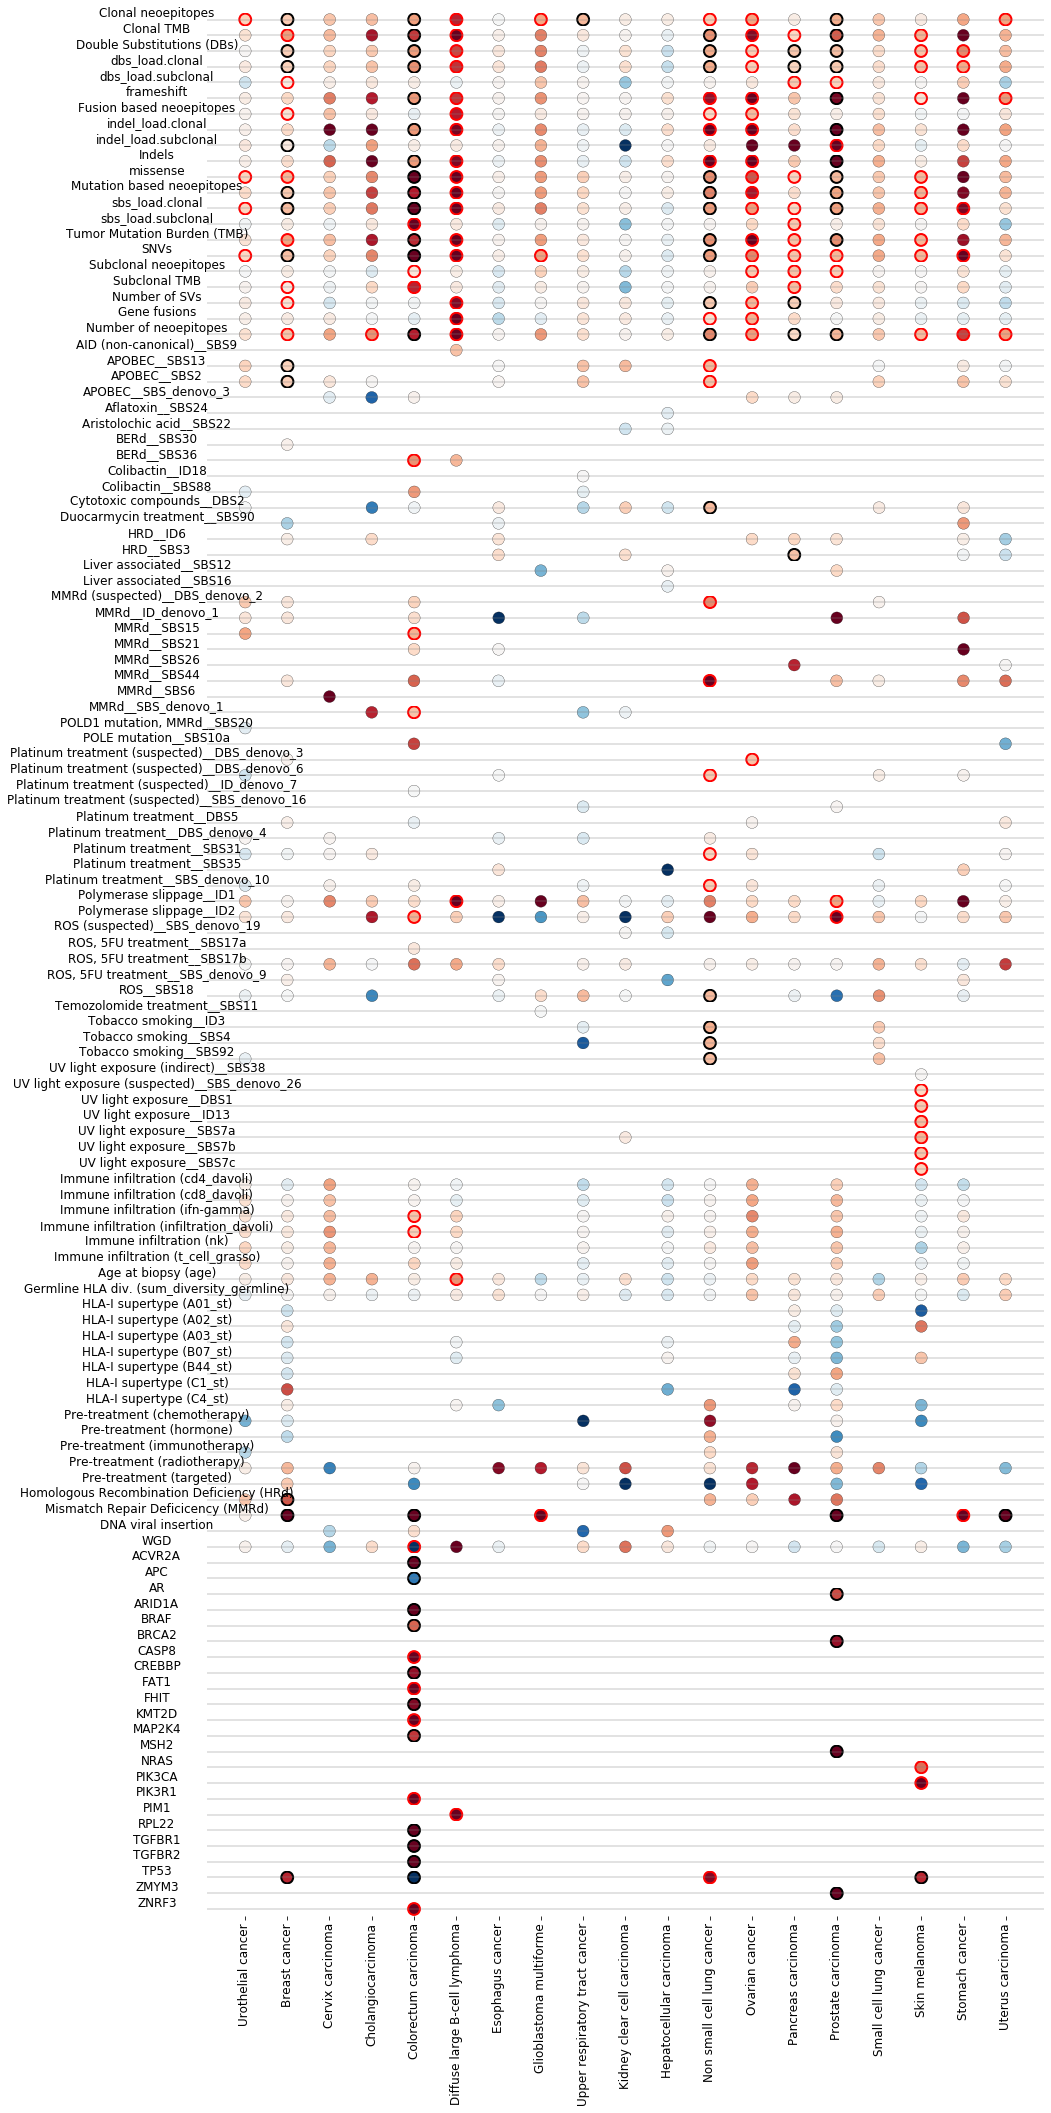

In [136]:
fig,ax = plt.subplots(figsize=(15,35),sharex=True)
cats=["Tumor Mutation Burden","Mutational Processes","Immune infiltration",'Age at biopsy','Germline HLA diversity','HLA-I supertype.', 'Pretreatment', 'DNA repair def.', 'DNA viral insertion','WGD','Drivers']
x_pos = len(df_total[(df_total["cat"].isin(cats))]["label"].unique())
gs = gridspec.GridSpec(ncols=1,nrows=x_pos,height_ratios=[1 for x in range(0,x_pos)])
axis=[]
for i in range(0,x_pos):
    axis.append(plt.subplot(gs[i]))

i=0
for cat_s in cats:
    q_cat = df_total[df_total["cat"]==cat_s].sort_values("label")
    labels_t = sorted(list(q_cat["label"].unique()))
    for label in labels_t:
        ax=axis[i]
        ax.get_xaxis().set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['left'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
        ax.set_yticks([])
        if cat_s == "Drivers":
            threshold=0.01
        else:
            threshold=0.02
        colors=[m_c.to_rgba(qv) if np.isfinite(qv)  else "white" for qv in odds_ratio.loc[(cat_s,label)][ttypes]]
        if label in (baseline_positive.index):
            background_pos=[baseline <= threshold for baseline in baseline_positive.loc[label][ttypes]]
            background_neg=[baseline <= threshold for baseline in baseline_negative.loc[label][ttypes]]
        else:
            background_pos=[True for n in range(len(ttypes)) ]
            background_neg=[True for n in range(len(ttypes)) ]
        odds=odds_ratio.loc[(cat_s,label)][ttypes]
        colors=[m_c.to_rgba(qv) if np.isfinite(qv)  else "white" for qv in odds_ratio.loc[(cat_s,label)][ttypes]]
        sizes=[140 if np.isfinite(qv)  else 0 for qv in odds_ratio.loc[(cat_s,label)][ttypes]]
        lw=[2.0 if (qv<0.05) else np.isfinite(qv)*0.25 for k,qv in enumerate(qvalue.loc[(cat_s,label)][ttypes])]
        ec=["red" if (qv<0.05 and ((odds[k]>0 and background_pos[k])or(odds[k]<0 and background_neg[k])))  else "black" for k,qv in enumerate(qvalue.loc[(cat_s,label)][ttypes])]
        ax.scatter(x=range(0,len(ttypes)),y=[0.5 for x in range(len(ttypes))],color=colors,s=sizes,lw=lw,edgecolor=ec)
        ax.set_ylabel(label if not(label in dict_labels) else dict_labels[label],fontsize=12,rotation=0,labelpad=50)
        ax.axhline(y=0.5,lw=0.45,color="grey")
        i=i+1
ax.get_xaxis().set_visible(True)
ax.set_xticks(list(range(len(ttypes))))
_=ax.set_xticklabels([d_labels_i[t] for t in ttypes],rotation=90,fontsize=12)
plt.savefig(f'../results/figures/figure7/heatmap_full_info_with_background_control_excluding_loh_hla.pdf', dpi=800,bbox_inches="tight")

### Heatmap only significant (Main Fig. 7a)

In [137]:
banned=["sbs_load.clonal","sbs_load.subclonal","dbs_load.clonal","dbs_load.subclonal","indel_load.clonal","indel_load.subclonal","clonal_tmb_indels","missense","frameshift"]
order_tmb=["smnv_load","clonal_tmb","subclonal_tmb","snvs","indels","dbs","total_fusions","svTumorMutationalBurden","total_neo","clonal_neo","subclonal_neo","mut_neo","fusion_neo"]

In [138]:
dict_labels={"smnv_load":"Tumor Mutation Burden (TMB)","clonal_tmb":"Clonal TMB","subclonal_tmb":"Subclonal TMB","snvs":"SNVs","indels":"Indels","dbs":"Double Substitutions (DBs)",
            "total_fusions":"Gene fusions","svTumorMutationalBurden":"Number of SVs","total_neo":"Number of neoepitopes","clonal_neo":"Clonal neoepitopes","subclonal_neo":"Subclonal neoepitopes",
            "mut_neo":"Mutation based neoepitopes","fusion_neo":"Fusion based neoepitopes","HRd":"Homologous Recombination Deficiency (HRd)","MMRd":"Mismatch Repair Deficicency (MMRd)"}

Tumor Mutation Burden 13
Mutational Processes 19


/home/fran/miniconda3/envs/global/lib/python3.6/site-packages/matplotlib/colors.py:235: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  c = np.array(c)
/home/fran/.local/lib/python3.6/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


Immune infiltration 2
DNA repair def. 1
DNA viral insertion 0
WGD 1
Drivers 9


/home/fran/miniconda3/envs/global/lib/python3.6/site-packages/matplotlib/colors.py:235: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  c = np.array(c)
/home/fran/.local/lib/python3.6/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)
/home/fran/miniconda3/envs/global/lib/python3.6/site-packages/matplotlib/colors.py:235: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with di

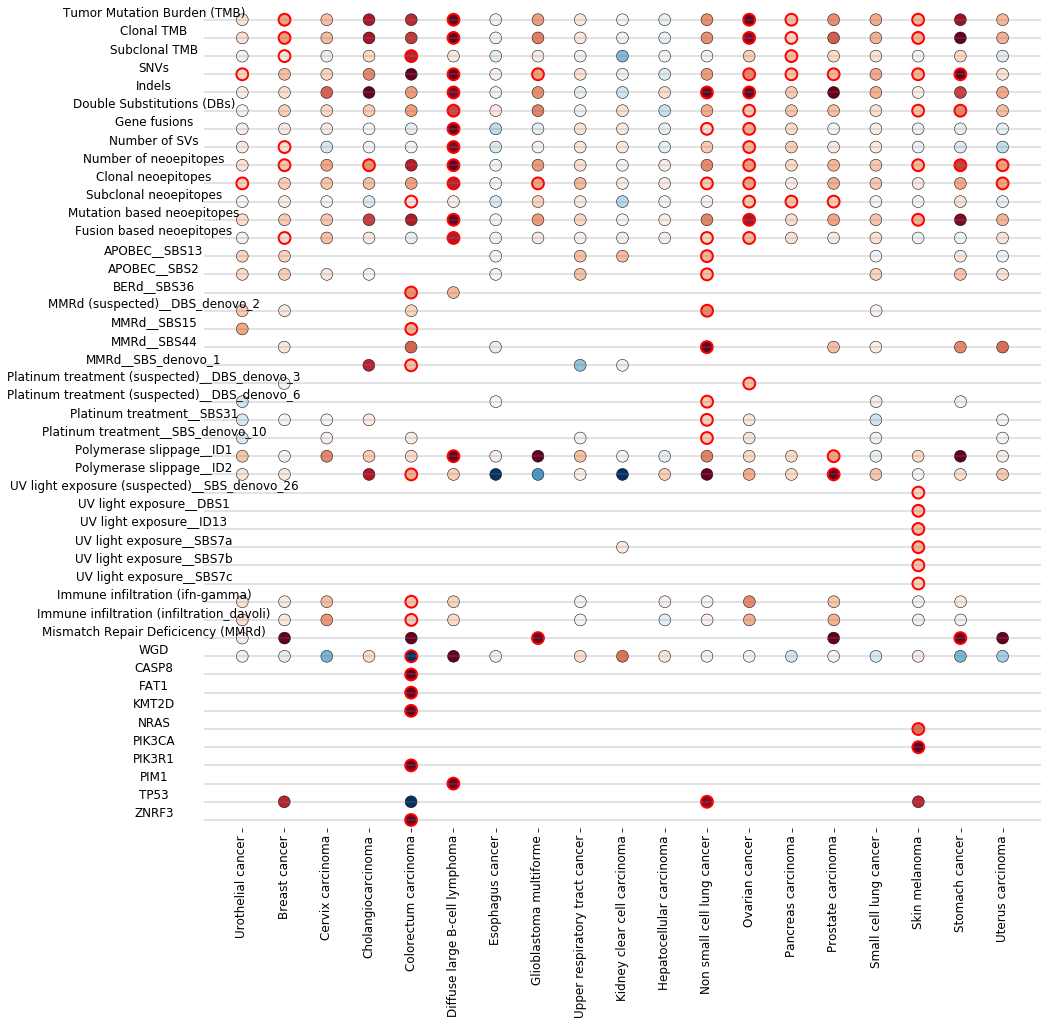

In [139]:
fig,ax = plt.subplots(figsize=(15,15),sharex=True)
cats=["Tumor Mutation Burden","Mutational Processes","Immune infiltration",'DNA repair def.', 'DNA viral insertion','WGD','Drivers']
x_pos = len(set(list(df_total[(df_total["cat"].isin(cats))&(df_total["not_significant_simulatedGIE"]==True)&(~df_total["label"].isin(banned))]["label"].unique())+order_tmb))
gs = gridspec.GridSpec(ncols=1,nrows=x_pos,height_ratios=[1 for x in range(0,x_pos)])
axis=[]
for i in range(0,x_pos):
    axis.append(plt.subplot(gs[i]))
i=0
for cat_s in cats:
    q_cat = df_total[df_total["cat"]==cat_s].sort_values("label")
    labels_t = sorted(list(q_cat[(q_cat["not_significant_simulatedGIE"]==True)&((~q_cat["label"].isin(banned)))]["label"].unique()))
    if cat_s == "Tumor Mutation Burden":
        labels_t=order_tmb
    print (cat_s,len(labels_t))
    for label in labels_t:
        ax=axis[i]
        ax.get_xaxis().set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['left'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
        ax.set_yticks([])
        colors=[m_c.to_rgba(qv) if np.isfinite(qv)  else "white" for qv in odds_ratio.loc[(cat_s,label)][ttypes]]
        sizes=[140 if np.isfinite(qv)  else 0 for qv in odds_ratio.loc[(cat_s,label)][ttypes]]
        lw=[2.0 if (sg) else 0.5 for k,sg in enumerate(significance_control.loc[(cat_s,label)][ttypes])]
        ec=["red" if (sg) else "black" for k,sg in enumerate(significance_control.loc[(cat_s,label)][ttypes])]
        ax.scatter(x=range(0,len(ttypes)),y=[0.5 for x in range(len(ttypes))],color=colors,s=sizes,lw=lw,edgecolor=ec)
        ax.set_ylabel(label if not(label in dict_labels) else dict_labels[label],fontsize=12,rotation=0,labelpad=50)
        ax.axhline(y=0.5,lw=0.45,color="grey")
        i=i+1
ax.get_xaxis().set_visible(True)
ax.set_xticks(list(range(len(ttypes))))
_=ax.set_xticklabels([d_labels_i[t] for t in ttypes],rotation=90,fontsize=12)
plt.savefig(f'../results/figures/figure7/heatmap_selected_info_with_background_control_excluding_loh_hla.pdf', dpi=800,bbox_inches="tight")

### Compare overlap with original regressions

In [140]:
df_global = pd.read_csv("../results/data/results_feature_correlation/significant_hits_gie.tsv",sep="\t")
print ("Number of significant pairs (all GIE) ", df_global[["cancer_type_code","label"]].drop_duplicates().shape[0])
significant_loh_excluded = df_total[(df_total["cat"].isin(cats))&(df_total["not_significant_simulatedGIE"])&(~df_total["label"].isin(banned))]
merged=df_global[["cancer_type_code","label"]].merge(significant_loh_excluded[["cancer_type_code","label"]])
print ("Number of significant pairs preserved, after excluding LOH HLA ", merged.shape[0])
print ("Fraction of significant pairs preserved, after excluding LOH HLA ", merged.shape[0] / df_global.shape[0])

merged


Number of significant pairs (all GIE)  65
Number of significant pairs preserved, after excluding LOH HLA  45
Fraction of significant pairs preserved, after excluding LOH HLA  0.6923076923076923


,cancer_type_code,label
0,NSCLC,indels
1,BRCA,clonal_tmb
2,SKCM,clonal_tmb
3,DLBCL,total_neo
4,SKCM,mut_neo
5,SKCM,snvs
6,SKCM,smnv_load
7,SKCM,total_neo
8,NSCLC,fusion_neo
9,SKCM,dbs
